In [1]:
%load_ext rpy2.ipython

In [3]:
%%R
library(phyloseq)
library(readr)
library(dplyr)
library(ggplot2)

In [5]:
%%R
otu_tab = read_csv("data/EC_table.noMC.csv") %>% {
    rownames(.) = .$seq_id
    .
    } %>%
    select(-seq_id) %>%
    as.matrix %>%
    phyloseq::otu_table(taxa_are_rows = TRUE)

tax_tab = read_csv("data/tax_table.csv") %>% {
    rownames(.) = .$seq_id
    .
    } %>%
    select(-seq_id) %>%
    as.matrix %>%
    tax_table

sample_tab = read_csv("data/sample_data.csv") %>% {
    rownames(.) = .$sample
    .
    } %>%
    select(-sample) %>%
    data.frame %>%
    sample_data

tree = phy_tree(ape::read.tree("data/variants.tree"))

ps = phyloseq(otu_tab, tax_tab, sample_tab, tree) %>%
     prune_samples((phyloseq::sampleSums(.) > 1000)&
                  (phyloseq::sample_data(.)$star == "star"), .) %>%
     transform_sample_counts(function(x) x / sum(x))
        
ps     

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9292 taxa and 75 samples ]
sample_data() Sample Data:       [ 75 samples by 7 sample variables ]
tax_table()   Taxonomy Table:    [ 9292 taxa by 9 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9292 tips and 9288 internal nodes ]


### Relative Abundance of Tenericutes

In [6]:
%%R
Tenericutes = subset_taxa(ps, Rank2 %in% "Tenericutes")

In [7]:
%%R
mdften = psmelt(Tenericutes)

In [ ]:
%%R

topNten = mdften %>%
    group_by(Sample_number,Sample,Genus.Species) %>%
    summarize(m= sum(Abundance)) %>%
    arrange(desc(m))

topNten

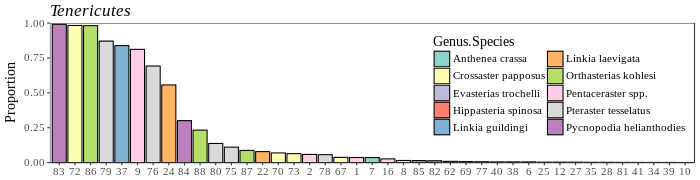

In [14]:
%%R -h 180 -w 700
p = ggplot(topNten[which(topNten$m>0.001),],aes(x= reorder(Sample_number,-m), y = m)) 

p = p + geom_bar(aes(fill = Genus.Species),stat="identity",color="black")

p = p + theme_bw() + theme(text=element_text(size=14, color="black",family ="Times New Roman"),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank(),                         
                           legend.position=c(0.79,0.55),
                           plot.title = element_text(lineheight=.8,face="italic"),
                           legend.key.size = unit(0.6, "cm"),
                           axis.title.x=element_blank())


p = p + scale_y_continuous(expand = c(0,0),limits = c(0, 1)) + scale_fill_brewer(palette = "Set3")

p = p + guides(fill=guide_legend(title = "Genus Species"))

p = p + guides(fill=guide_legend(ncol=2))

p = p + ylab("Proportion") + ggtitle("Tenericutes")

p

### Relative Abundance of Spirochaetae

In [16]:
%%R
Spirochaetae = subset_taxa(ps, Rank2 %in% "Spirochaetae")

In [17]:
%%R
mdfspiro = psmelt(Spirochaetae)

In [ ]:
%%R

topNspiro = mdfspiro %>%
    group_by(Sample_number,Sample,Genus.Species) %>%
    summarize(m= sum(Abundance)) %>%
    arrange(desc(m))

topNspiro

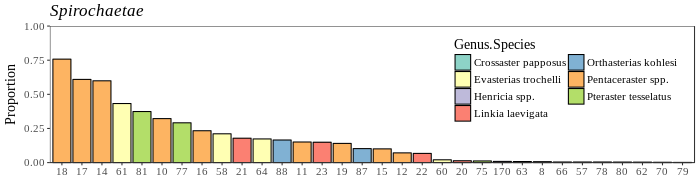

In [19]:
%%R -h 180 -w 700
p = ggplot(topNspiro[which(topNspiro$m>0.001),],aes(x= reorder(Sample_number,-m), y = m))

p = p + geom_bar(aes(fill = Genus.Species),stat="identity", color="black")

p = p + theme_bw() + theme(text=element_text(size=14, color="black",family ="Times New Roman"),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank(),                         
                           legend.position=c(0.8,0.6),
                           plot.title = element_text(lineheight=.8,face="italic"),
                           legend.key.size = unit(0.6, "cm"),
                           axis.title.x=element_blank())


p = p + scale_y_continuous(expand = c(0,0),limits = c(0, 1)) + scale_fill_brewer(palette = "Set3")

p = p + guides(fill = guide_legend(title = "Genus Species"))

p = p + guides(fill=guide_legend(ncol=2))

p = p + ylab("Proportion") + ggtitle("Spirochaetae")
               
p 

### Top  6 Phyla

In [21]:
%%R
mdf = psmelt(ps)

In [22]:
%%R

N = 6

topN = mdf %>%
    group_by(Sample_number,Sample, Rank2) %>%
    summarize(Abundance = sum(Abundance)) %>%
    group_by(Rank2) %>%
    summarize(m = mean(Abundance)) %>%
    top_n(N) %>%
    arrange(desc(m)) %>%
    magrittr::extract2("Rank2")

In [24]:
%%R

mdf.other = mdf %>%
    mutate(Rank2.other = ifelse(Rank2 %in% topN, as.character(Rank2), "Other")) %>%
    group_by(Sample_number,Sample, Sample.Type, Rank2.other) %>%
    summarize(Abundance = sum(Abundance))

head(mdf.other)

Source: local data frame [6 x 5]
Groups: Sample_number, Sample, Sample.Type [1]

  Sample_number Sample Sample.Type    Rank2.other  Abundance
          <int>  <chr>       <chr>          <chr>      <dbl>
1             1 CF1_CF          CF Actinobacteria 0.04163133
2             1 CF1_CF          CF  Bacteroidetes 0.01417744
3             1 CF1_CF          CF     Firmicutes 0.07639919
4             1 CF1_CF          CF          Other 0.04380432
5             1 CF1_CF          CF Proteobacteria 0.78760335
6             1 CF1_CF          CF   Spirochaetae 0.00000000


In [74]:
%%R
write.csv(mdf.other, file = "mdf.other.csv")

In [25]:
%%R
mdf.summary = mdf.other %>%
    group_by(Rank2.other) %>%
    summarise(avg = mean(Abundance), 
              sd = sd(Abundance), 
              sem = sd(Abundance)/sqrt(length(Abundance)),
              proportion = round(avg*100,2)) %>%
    arrange(desc(avg))

mdf.summary

# A tibble: 7 × 5
     Rank2.other        avg         sd         sem proportion
           <chr>      <dbl>      <dbl>       <dbl>      <dbl>
1 Proteobacteria 0.72296831 0.26778875 0.030921581      72.30
2    Tenericutes 0.10883835 0.26360130 0.030438056      10.88
3   Spirochaetae 0.06971469 0.15332619 0.017704583       6.97
4          Other 0.04387990 0.08933443 0.010315451       4.39
5 Actinobacteria 0.02310526 0.01797416 0.002075477       2.31
6  Bacteroidetes 0.01768949 0.03209967 0.003706551       1.77
7     Firmicutes 0.01380400 0.01836013 0.002120045       1.38


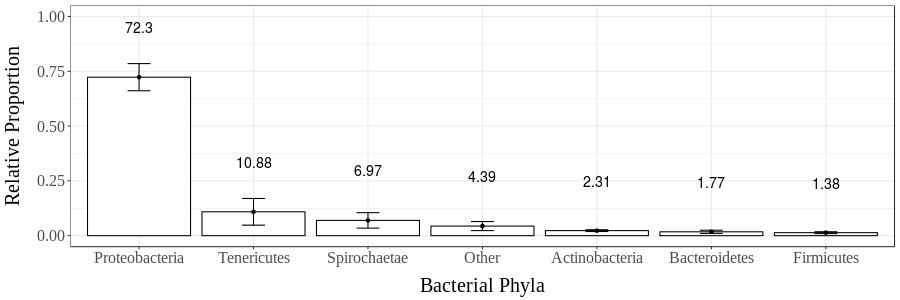

In [31]:
%%R -w 900 -h 300

p = ggplot(mdf.summary, aes(x= reorder(Rank2.other,-avg), y = avg)) 

p = p + geom_bar(stat="identity",fill="white", colour="black")

p = p + theme_bw() + theme(text=element_text(size=20, color="black",family ="Times New Roman"),
                           #panel.grid.major = element_blank(),
                           #panel.grid.minor = element_blank(),
                           legend.position="none",
                           axis.title.y=element_text(margin=margin(0,15,0,0)),
                           axis.title.x=element_text(margin=margin(15,0,0,0)))

p = p + geom_point(aes(y = avg), color = "black", data = mdf.summary) +
    geom_errorbar(aes(y = avg, ymin = avg-(2*sem), ymax = avg+(2*sem)), 
                color = "black", width = 0.2, data = mdf.summary)

p = p + scale_y_continuous(limits = c(0, 1))

p = p + geom_text(aes(x=Rank2.other, label=proportion), vjust = -4, size=5) 

p = p + ylab("Relative Proportion") + xlab("Bacterial Phyla") 

p

### Stacked Bar Charts 

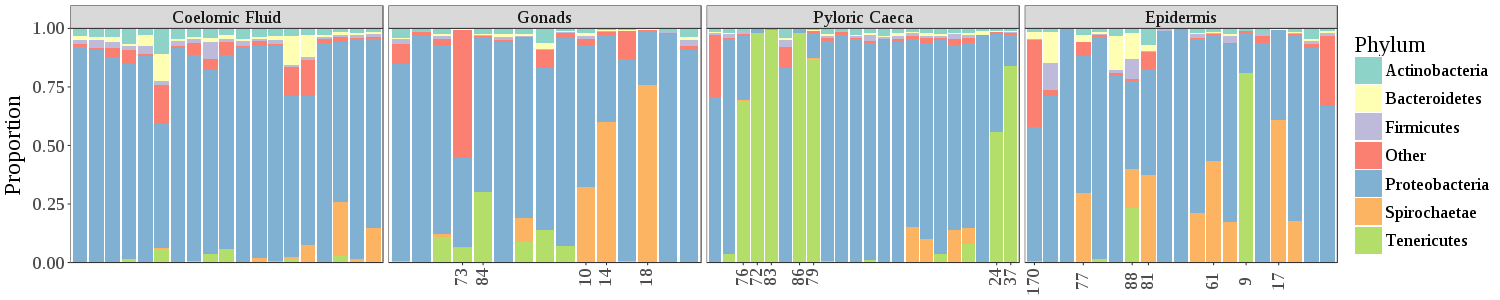

In [120]:
%%R -w 1500 -h 300

Samples = c(
                `X8530_G`="14", 
                `X8538_G`="18", 
                `C447_G`="73",
                `C394_PC`="76",
                `C446_PC`="72",
                `C512_PC`="83",
                `C556_PC`="86",
                `C560_PC`="79",
                `X8553_PC`="24",
                `X8567_PC`="37",
                `X8508_TF`="9",
                `X8537_TF`="17",
                `T1EVA5_BP`="61",
                `C562_TF`="81",
                `C558_TF`="88",
                `C209_3_TF`="170",
                `X8509_G`="10",
                `C395_TF`="77",
                `C515_G`="84"
                )

Tissuenames = c(
                    `PC` = "Pyloric Caeca",
                    `G` = "Gonads",
                    `CF` = "Coelomic Fluid",
                    `TF` = "Epidermis"
                    )

p = ggplot(mdf.other, aes(x=Sample, y = Abundance, fill = Rank2.other)) + labs(color = "Sample Type")

p = p + facet_grid(.~Sample.Type, scales = "free",labeller = as_labeller(Tissuenames))

p = p + ylab("Proportion") 

p = p + geom_bar(stat="identity")

p = p + scale_y_continuous(expand = c(0,0))+ scale_fill_brewer(palette = "Set3")

p = p + guides(fill = guide_legend(title = "Phylum"))

p = p + theme_bw() + theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,10,0,0)),
              text=element_text(size=23, color="black",family="Times New Roman"),
              panel.grid.minor = element_blank(),
              #axis.text.x = element_blank(),
              #axis.ticks = element_blank(),
              axis.text.x=element_text(angle=90,vjust=0.4),
              legend.key.size = unit(1, "cm"),
              axis.title.x=element_blank())

p = p + scale_x_discrete(labels=Samples,
                         breaks = c("X8530_G", "X8538_G", "C447_G","C394_PC","C446_PC",
                                   "C512_PC","C556_PC","C560_PC","X8553_PC","X8567_PC",
                                   "X8508_TF","X8537_TF","T1EVA5_BP","C562_TF","C558_TF",
                                    "C209_3_TF","X8509_G","C395_TF","C515_G"))

#p = p + scale_x_discrete(breaks=c("PC", "G", "TF","CF"),
#                      labels=c("Pyloric Ceaca", "Gonads", "Epidermis","Coelomic Fluid"))

p